# KNN Model



### Import libraries

In [1]:
import pandas as pd 
import numpy as np

# KNN Regression Model
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Used in the Error Analysis
from yellowbrick.regressor import PredictionError, ResidualsPlot

# required to safe the Model Parameters to MLFlow
import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

### Reading data file from "Featureengineering" output as .csv

In [2]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14579.56,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14579.56,1.021,0.1276,0.2552


### Read "Feature importance list" from .csv

In [3]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


A selection of the features is done by giving them a ModelImportence from 1 to 3, where 1 is importend, 2 maybe importend and 3 will be neglected.

In [4]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [5]:
df_model = df[list_imp_feat].copy()

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

The feature list for the model including the target: ME.FMS.act.tPh (fuel consumption of the Main Engine in t/h )

### Nan value treatment

In [7]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

The nan values in the tow features are filled with 0, after investigating the data and coming to the conclusion, that the vessel is in the harbour and the Mein Engine not running.

In [8]:
df_model.dropna(inplace=True)

The additional nan values are dropped, because the meaningful filling is not possible or to uncertain

In [9]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180149 entries, 1 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180149 non-null  float64
 1   ME.FTS.act.dgC           180149 non-null  float64
 2   HFO.GME.act.nodim        180149 non-null  float64
 3   V.COG.act.deg            180149 non-null  float64
 4   V.SOG.act.kn             180149 non-null  float64
 5   V.RUA.act.deg            180149 non-null  float64
 6   V.GPSLAT.act.deg         180149 non-null  float64
 7   V.GPSLON.act.deg         180149 non-null  float64
 8   WEA.WDT.act.deg          180149 non-null  float64
 9   WEA.WST.act.mPs          180149 non-null  float64
 10  V.SLPOG.act.PRC          180149 non-null  float64
 11  ME.SFCI.act.gPkWh        180149 non-null  float64
 12  DDM.TRIM.act.m           180149 non-null  float64
 13  DDM.DRAFT.act.m          180149 non-null  float64
 14  pass

### Correlation Matrix

<AxesSubplot:>

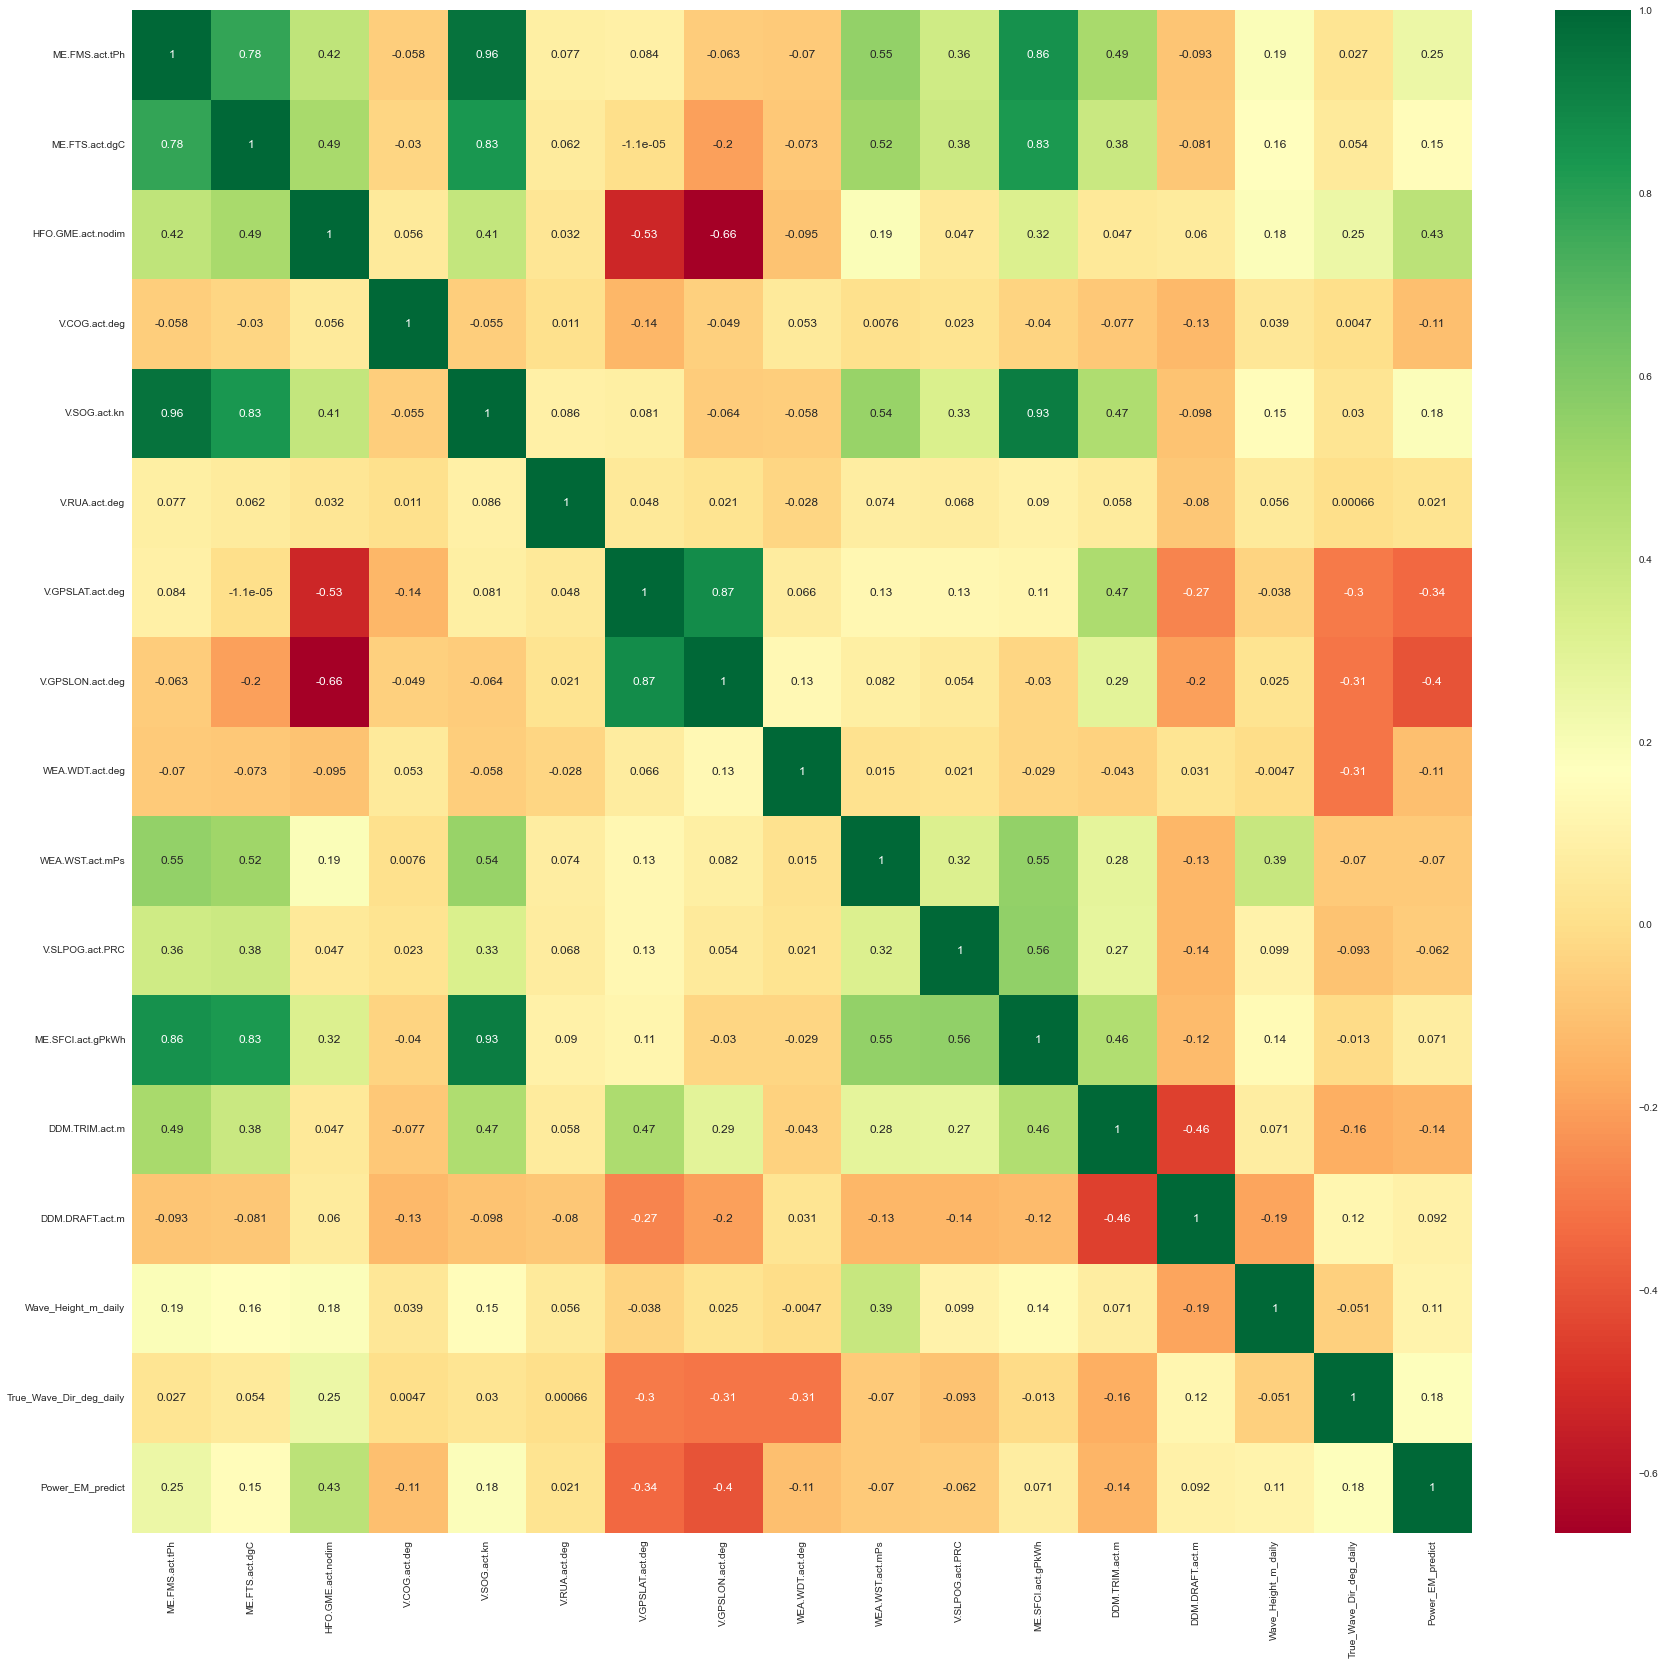

In [10]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

### Target and Feature definition

In [11]:
X = df_model.drop(['ME.FMS.act.tPh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

Target separation from the feature dataset.

### Test train split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.1, random_state = 42)

Test Train split with random_state = 42 to have comparable dataset for the different models. Due to the size fo the dataset the test size is set rather small with 10%:

### Dummy creation

In [13]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

For the passage type (Atalantic, Europe, South America) dummy features are created, to be able to feed the data to the model only as numerical values!

### Open MLFlow and definition of run name

In [14]:
# setting the MLFlow connection and experiment
#mlflow.set_tracking_uri(TRACKING_URI)
#mlflow.set_experiment(EXPERIMENT_NAME)
#mlflow.start_run(run_name='KNN')
#run = mlflow.active_run()

### Pipline with KNN Regressor and parameter definition

In [15]:
knn = make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=4,
                                                        metric='minkowski',
                                                        p=2,
                                                        n_jobs=-1)) 

Pipline set up, with the model parameters: n_neighbors, Metric, p and n_jobs. 
The number of jobs is set to -1 to start all CPUs to fit and predict the model.


### Fit Model

In [16]:
knn.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_jobs=-1, n_neighbors=4))])

Train the Model. For KNN this is very quick compared to other models. 

### Predict y

In [17]:
y_pred = knn.predict(X_test)


Predict on the test dataset is taking some time, because the distances between the target and all datapoints in the dataset have to be calucalted.

### Predict y on train data

In [18]:
y_pred_train = knn.predict(X_train)

To get residuals for the error analysis of regression models, the train datapoints have to be predicted as well.

### RMSE

In [19]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.08517308558832716
RMSE test:  0.11246717760804588


### Plot "Actuel" vs. "Predicted"

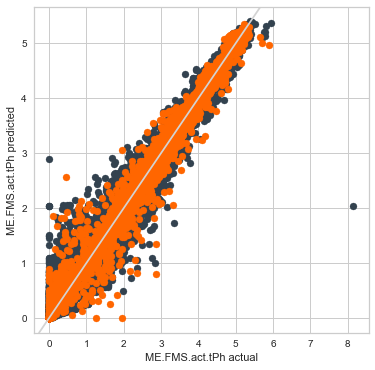

In [20]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
#plt.xticks(np.arange(0,501,100));
#plt.yticks(np.arange(0,501,100));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");
#plt.xlim(0, 450);
#plt.ylim(0, 450);

In [21]:
#visualizer = PredictionError(knn)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.show()                 # Finalize and render the figure

### Residual Plot

In [22]:
# calculate residuals
residuals_train = y_pred_train - y_train
residuals_test = y_pred - y_test

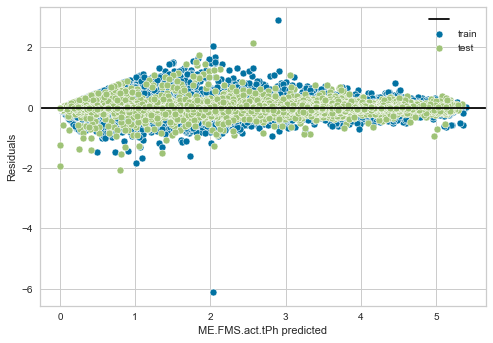

In [23]:
sns.scatterplot(x = y_pred_train, y = residuals_train)
sns.scatterplot(x = y_pred, y = residuals_test)
plt.axhline(y = 0, color = 'black')
plt.xlabel("ME.FMS.act.tPh predicted");
plt.ylabel("Residuals");
plt.legend(labels=['', 'train', 'test'])

In [24]:
#visualizer = ResidualsPlot(knn)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.show()  

## MLFlow parameters

In [25]:
#seting parameters that should be logged on MLFlow

params = {
    'csv used': 'Featureselection03.csv',
    'features drop' : 'Accroding to model importance list',
    'random_state' : 42,
    'NaN handling' : 'dropped',  
    'Shape' : df.shape,
    'Scaler' : 'MinMaxScaler',
    'K-Neighbors' : 4,
    'metric' : 'minkowski',
    'p' : 2
  }

Write down all parameters, which shall be uploaded to MLFlow. This can be different metrics for different models.

## Writing to MLFlow

In [26]:
#logging params to mlflow
#mlflow.log_params(params)

#setting tags
#mlflow.set_tag("running_from_jupyter", "True")

#logging metrics
#mlflow.log_metric("train-" + "RMSE", rmse_train)
#mlflow.log_metric("test-" + "RMSE", rmse_test)

# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
#mlflow.end_run()

Using standardScaler instead of MinMaxScaler give not better RMSE values for the model, hence the MinMAxScaler will be used for hte KNN Model.  
n_neighbors = 4  

MinMaxScaler:  
RMSE train:  0.085  
RMSE test:   0.112  

StandardScaler:  
RMSE train:  0.0998  
RMSE test:  0.135

### feature importance for KNN models is not available via 'feature importance'

#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso#Loading the dataset
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable
df.head()

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(knn.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")